In [1]:
!pip install gtts

In [2]:
# General imports
import os
import random
import pickle
import warnings
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# TensorFlow and Keras related imports
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, BatchNormalization, RepeatVector, Dot, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16, MobileNetV3Large, ResNet50
from tensorflow.keras.layers import Add
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import History
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.applications.vgg16 import preprocess_input 


# Handle warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from gtts import gTTS
from IPython.display import Audio, display


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# Caption Preprocessing:

In [4]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)


def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

clean(mapping)


100%|██████████| 40456/40456 [00:00<00:00, 672863.61it/s]


In [5]:
example_keys = list(mapping.keys())[:2]  
for key in example_keys:
    print(f"Image ID: {key}")
    for caption in mapping[key]:
        print(f"Cleaned Caption: {caption}")
    print("-" * 50)  


Image ID: 1000268201_693b08cb0e
Cleaned Caption: startseq child in pink dress is climbing up set of stairs in an entry way endseq
Cleaned Caption: startseq girl going into wooden building endseq
Cleaned Caption: startseq little girl climbing into wooden playhouse endseq
Cleaned Caption: startseq little girl climbing the stairs to her playhouse endseq
Cleaned Caption: startseq little girl in pink dress going into wooden cabin endseq
--------------------------------------------------
Image ID: 1001773457_577c3a7d70
Cleaned Caption: startseq black dog and spotted dog are fighting endseq
Cleaned Caption: startseq black dog and tri-colored dog playing with each other on the road endseq
Cleaned Caption: startseq black dog and white dog with brown spots are staring at each other in the street endseq
Cleaned Caption: startseq two dogs of different breeds looking at each other on the road endseq
Cleaned Caption: startseq two dogs on pavement moving toward each other endseq
---------------------

# Text Tokenization:

In [6]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

pickle.dump(tokenizer, open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb'))


In [7]:
len(all_captions)

40455

In [8]:
vocab_size

8485

# Splitting Dataset:

In [9]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

print("Number of training samples:", len(train))
print("Number of testing samples:", len(test))

max_length = max(len(caption.split()) for caption in all_captions)
print("Maximum Caption Length:",(max_length))


Number of training samples: 7281
Number of testing samples: 810
Maximum Caption Length: 35


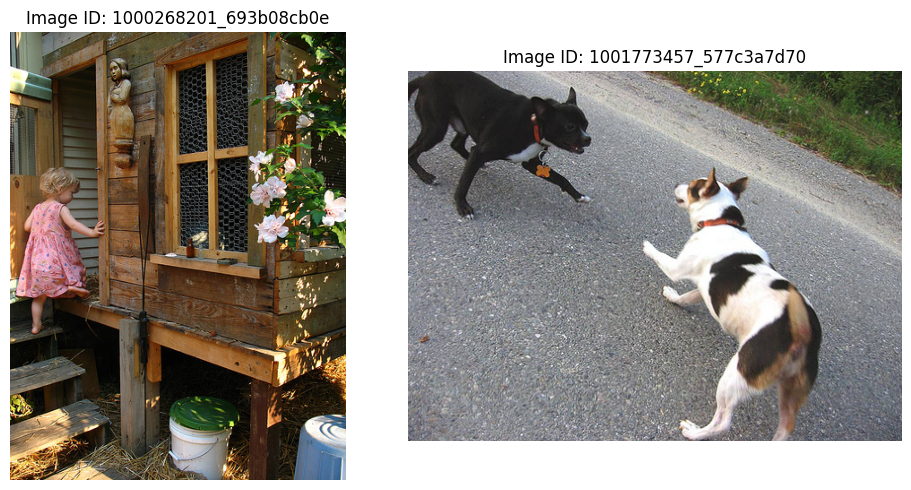

In [10]:
IMAGES_DIR = os.path.join(BASE_DIR, 'Images')

image_files = list(mapping.keys())[:2]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

for i, image_id in enumerate(image_files):
    image_path = os.path.join(IMAGES_DIR, image_id + '.jpg')  
    if os.path.exists(image_path): 
        img = mpimg.imread(image_path)
        axes[i].imshow(img) 
        axes[i].set_title(f"Image ID: {image_id}")
        axes[i].axis('off')  
    else:
        print(f"Image {image_id}.jpg not found in the dataset.")

plt.tight_layout() 
plt.show()


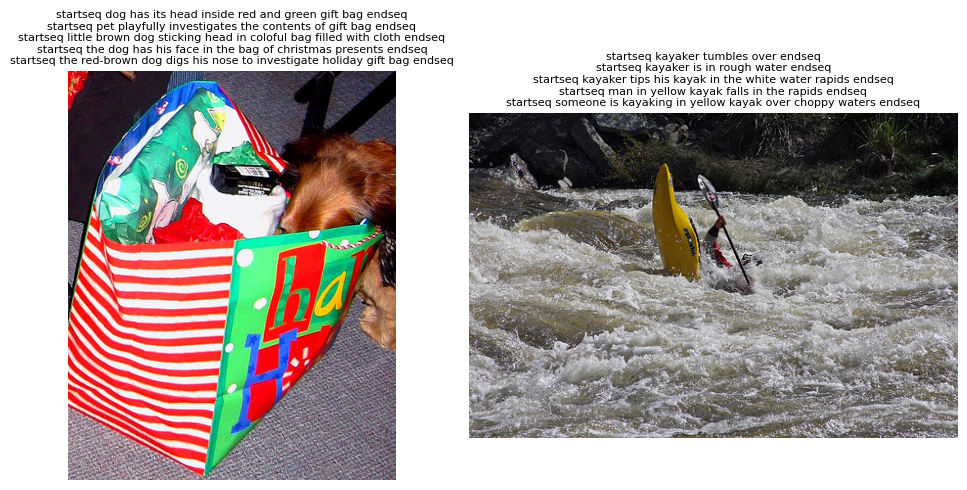

In [11]:
def display_random_images(directory, mapping, num_images=2):
   
    image_ids = random.sample(list(mapping.keys()), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    
    for i, image_id in enumerate(image_ids):
        img_path = os.path.join(directory, image_id + '.jpg') 
        
        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            
            axes[i].imshow(img)
            axes[i].axis('off')  
            
            captions = mapping[image_id]
            caption_text = "\n".join(captions)
            axes[i].set_title(caption_text, fontsize=8, wrap=True)
        else:
            axes[i].axis('off')  
            axes[i].set_title(f"Image {image_id}.jpg not found.", fontsize=12)
    
    plt.tight_layout()
    plt.show()


image_directory = os.path.join(BASE_DIR, 'Images')
display_random_images(image_directory, mapping)


So, here we are done with Captions:
1. Mapping
2. Cleaning
3. Tokenizing 

# MODEL:

# VGG16:

In [12]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#print(model.summary())


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [13]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1733149963.636184      79 service.cc:145] XLA service 0x7c953c004fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733149963.636242      79 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733149963.636246      79 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733149967.477781      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [11:11<00:00, 12.05it/s]


In [14]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'VGG16features.pkl'), 'wb'))


In [15]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0


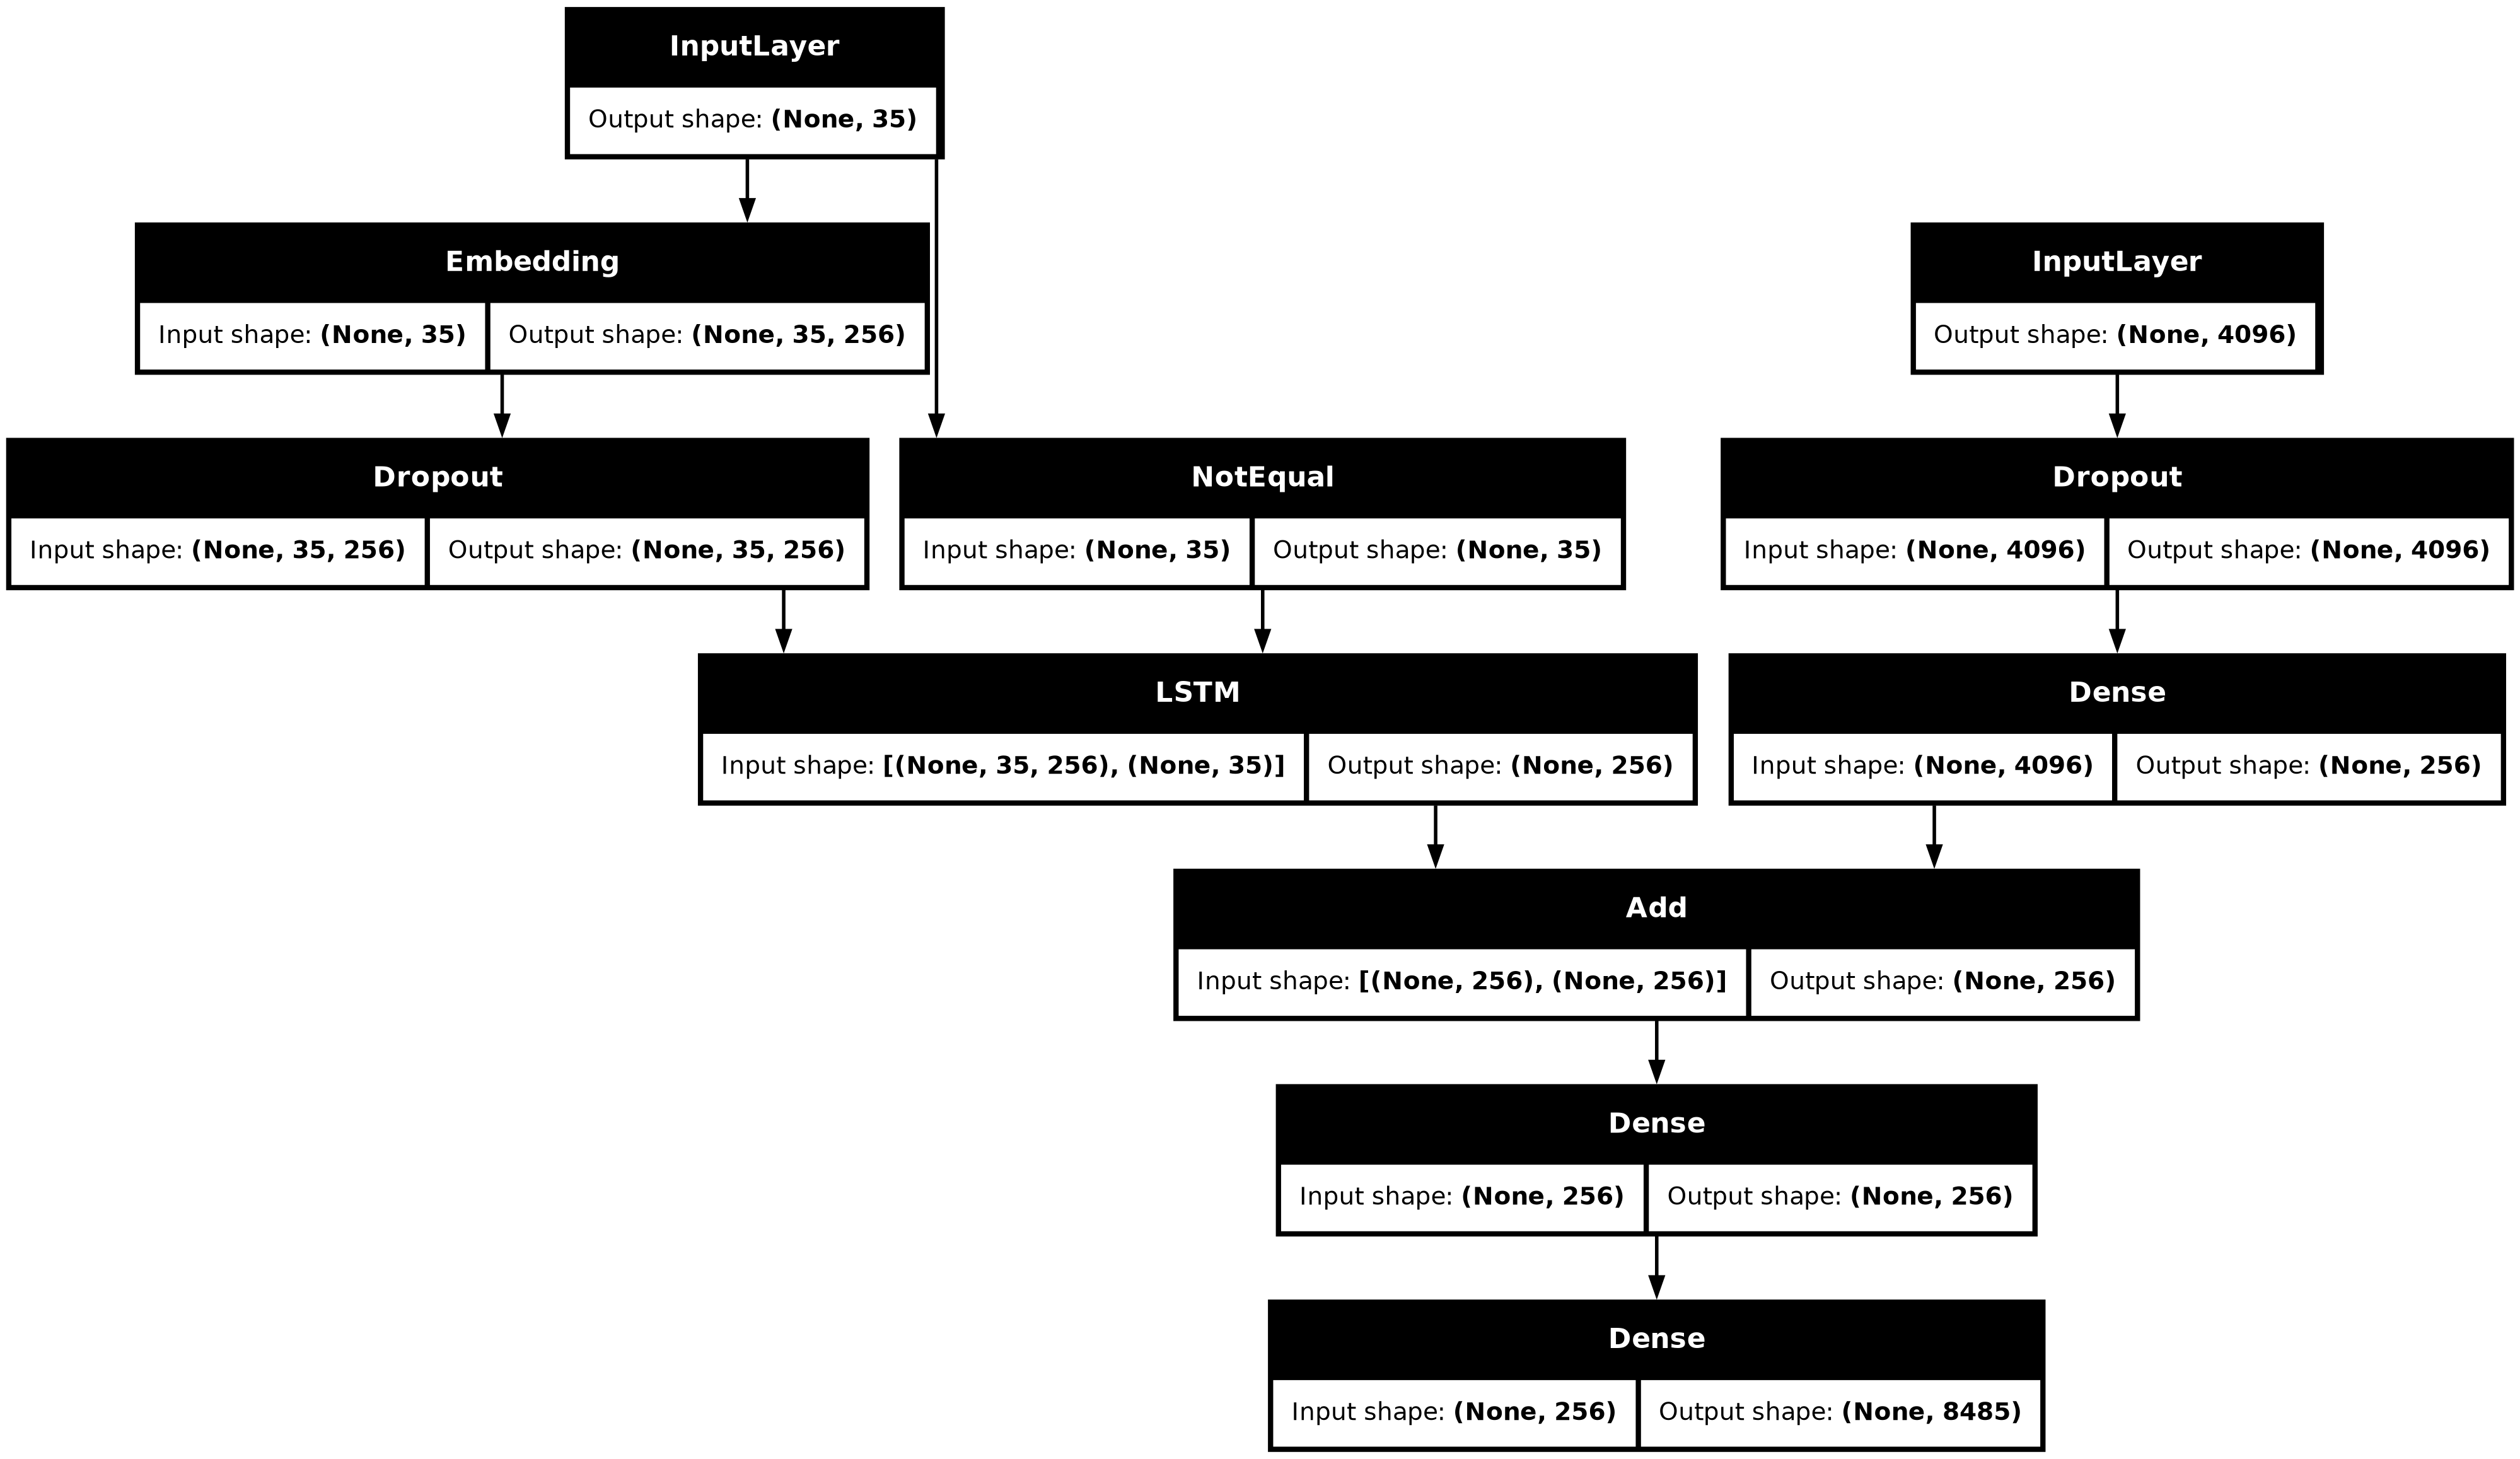

In [16]:
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=['accuracy'])
plot_model(model, show_shapes=True)


In [17]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size

history = History()

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[history])


227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 237ms/step - accuracy: 0.1164 - loss: 5.7851
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 236ms/step - accuracy: 0.2531 - loss: 4.0607
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - accuracy: 0.2898 - loss: 3.5865
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 235ms/step - accuracy: 0.3102 - loss: 3.3118
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 233ms/step - accuracy: 0.3263 - loss: 3.1120
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step - accuracy: 0.3407 - loss: 2.9560
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 233ms/step - accuracy: 0.3552 - loss: 2.8282
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 231ms/step - accuracy: 0.3655 - loss: 2.7349
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 233ms/step - accuracy: 0.3771 - loss: 2.6534
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.3851 - loss: 2.5826
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 237ms/step - accuracy: 0.3947 - loss: 2.5265
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - accuracy: 0.4020 - loss: 2.4681
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - accuracy: 0.4089 -

In [18]:
model.save('VGG16model.keras')


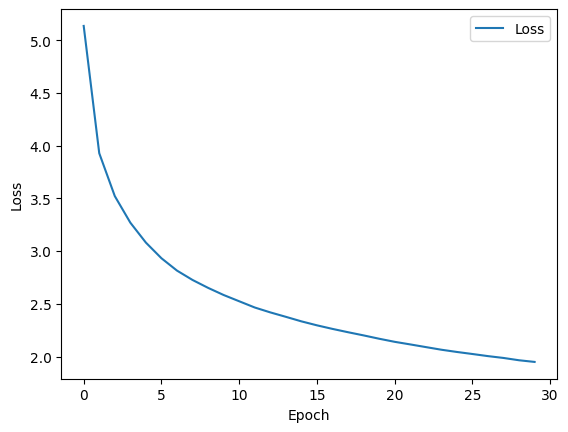

In [19]:
train_loss = history.history['loss']

plt.plot(train_loss, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


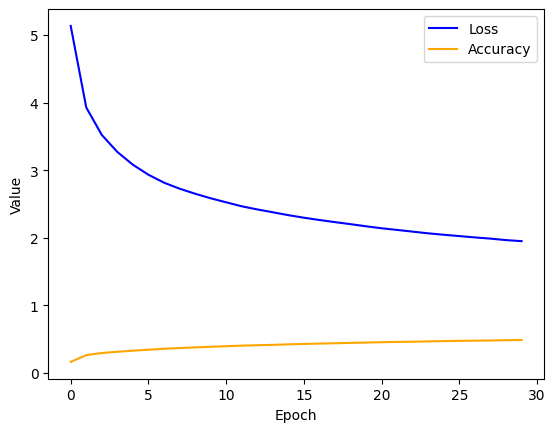

In [20]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

plt.plot(train_loss, label='Loss', color='blue')  
plt.plot(train_accuracy, label='Accuracy', color='orange') 

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()


# VGG16 - Results:

In [21]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text


In [22]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    
    img_path = os.path.join(BASE_DIR, "Images", image_name)  
    image = Image.open(img_path)
    
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    y_pred = y_pred.replace('startseq', '').replace('endseq', '').strip()
        
    print("Generated Caption: ", y_pred)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    tts = gTTS(y_pred, lang='en')
    audio_path = f"predicted_caption_{image_name.split('.')[0]}.mp3"
    tts.save(audio_path)

    print("Click to play audio:")
    display(Audio(audio_path))
    print("\n\n")
# generate_caption("1015118661_980735411b.jpg")


Generated Caption:  two dogs are playing together on the grass


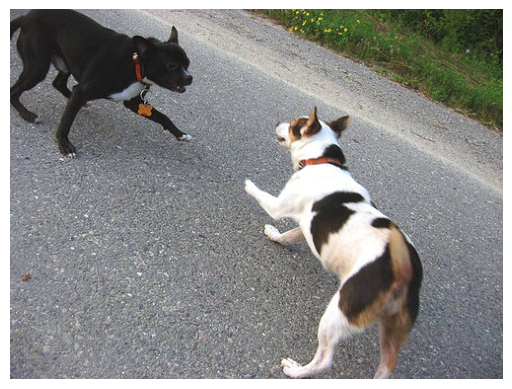

Click to play audio:





Generated Caption:  black dog is carrying something in its mouth


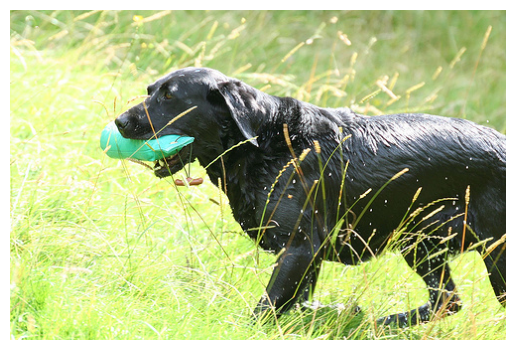

Click to play audio:





Generated Caption:  boy in red shirt and blue cap is kneeling on metal beam


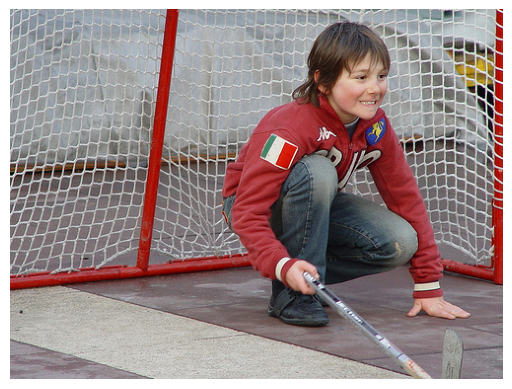

Click to play audio:





Generated Caption:  man is performing trick on his rollerblades


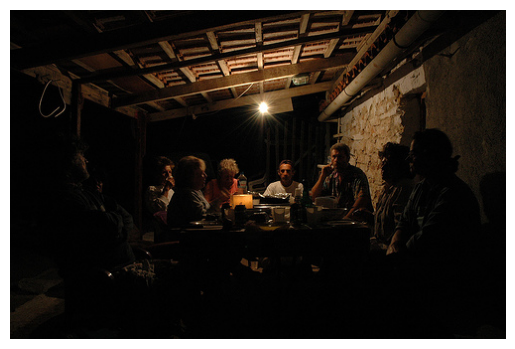

Click to play audio:


In [23]:
generate_caption("1001773457_577c3a7d70.jpg")
generate_caption("1026685415_0431cbf574.jpg")
generate_caption("103106960_e8a41d64f8.jpg")
generate_caption("107582366_d86f2d3347.jpg")


# VGG16 - BELU Score:

In [24]:
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)


vggbleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
vggbleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
vggbleu_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
vggbleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))


print("Final BLEU-1 for VGG16: %f" % vggbleu_1)
print("Final BLEU-2 for VGG16: %f" % vggbleu_2)
print("Final BLEU-3 for VGG16: %f" % vggbleu_3)
print("Final BLEU-4 for VGG16: %f" % vggbleu_4)

100%|██████████| 810/810 [07:23<00:00,  1.83it/s]


Final BLEU-1 for VGG16: 0.548298
Final BLEU-2 for VGG16: 0.321410
Final BLEU-3 for VGG16: 0.201932
Final BLEU-4 for VGG16: 0.120200


In [25]:
# Save VGG16 BLEU scores
vgg_bleu_scores = {
    'BLEU-1': vggbleu_1,
    'BLEU-2': vggbleu_2,
    'BLEU-3': vggbleu_3,
    'BLEU-4': vggbleu_4
}

# Save to a .pkl file
with open('vgg16_bleu_scores.pkl', 'wb') as f:
    pickle.dump(vgg_bleu_scores, f)

print("VGG16 BLEU scores saved to vgg16_bleu_scores.pkl")


VGG16 BLEU scores saved to vgg16_bleu_scores.pkl


Here we're done with our VGG16+LSTM model.